# VM: Deep Learning mit Python - Model from scratch

*Group: Leo Giesen, Johannes Kauffmann*

Case Study: Create deep learning model to predict Land Use and Land Cover data drom satellite pictures.

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Wirtschaftsinformatik/lulc_data'

Mounted at /content/gdrive


In [2]:
# Imports

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import calendar
import os
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from imblearn.over_sampling import RandomOverSampler
import tensorflow_hub as hub
from keras.callbacks import EarlyStopping

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


**Define class names and channel names**

In [3]:
# Class names

class_names = {
    0: "No Data", 
    1: "Cultivated Land",
    2: "Forest",
    3: "Grassland",
    4: "Shrubland",
    5: "Water",
    6: "Wetlands",
    7: "Tundra",
    8: "Artificial Surface",
    9: "Bareland",
    10: "Snow and Ice"
}

In [4]:
# Channel names

channel_names = {
    1: "Red",
    2: "Green",
    3: "Blue",
    4: "NIR 1",
    5: "NIR 2",
    6: "NIR 3"
}

**Loading data**

In [5]:
data = data = np.load(root_path + '/train.npz')
bands = data['bands'] # data: 10.000 patches, each for twelve months and with six channels. Resolution: 33x33 pixels
lulc = data['lulc'] # labels for central pixel of patches (Land Use and Land Cover)
print(bands.shape)
print(lulc.shape)

(10000, 12, 33, 33, 6)
(10000,)


In [6]:
# show number of instances per class

count_classes = []
for i in range(11): 
    val = np.count_nonzero(lulc == i)
    print("class "+str(i)+": "+str(val))
    count_classes.append(val)
#print(count_classes)

class 0: 1308
class 1: 238
class 2: 5796
class 3: 1125
class 4: 770
class 5: 58
class 6: 0
class 7: 0
class 8: 217
class 9: 488
class 10: 0


--> Realization: Class 2 is over-represented. Classes 6, 7 and 10 are not present in the data set at all.

Channels from patch no. 250
Central pixel is labeled as Cultivated Land


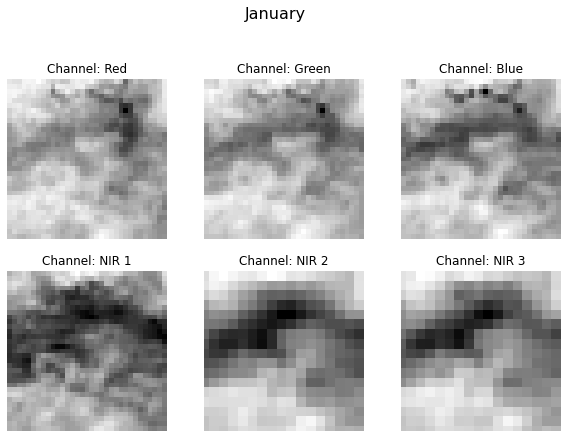

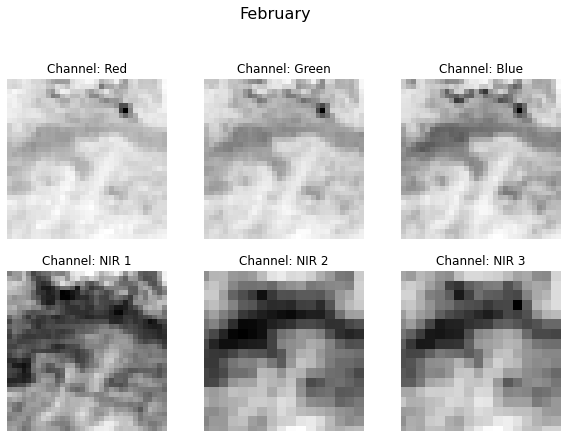

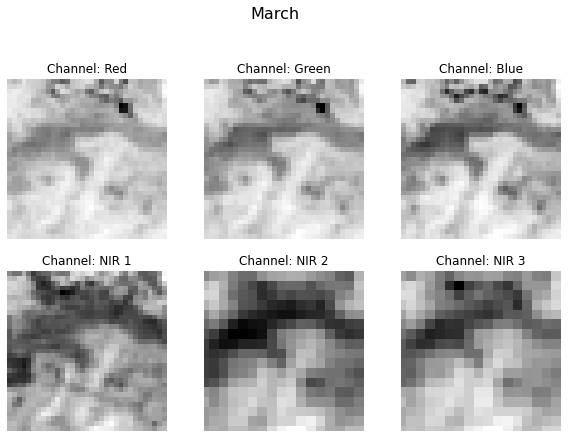

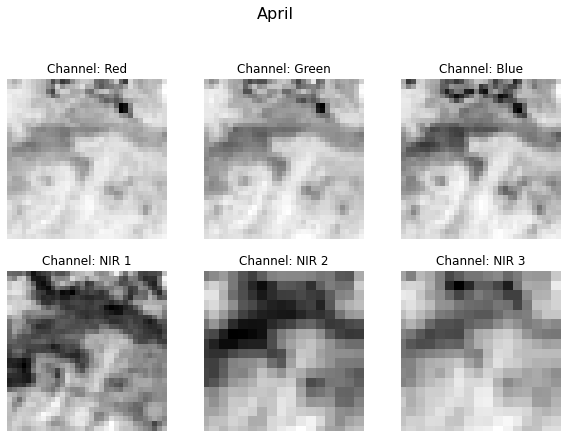

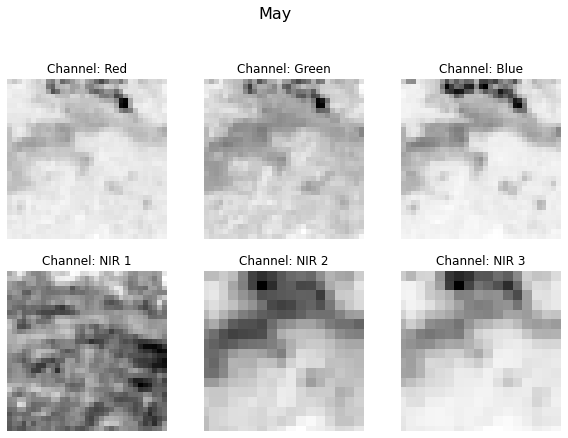

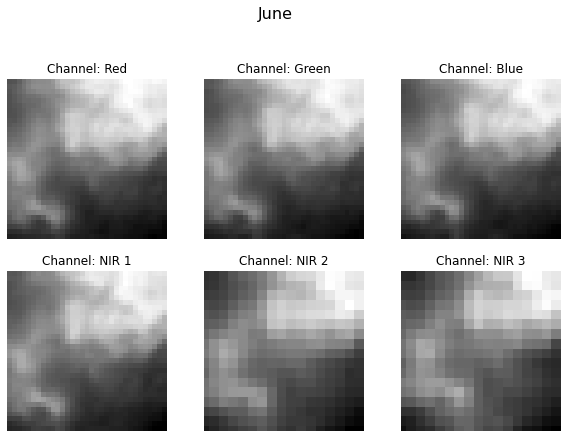

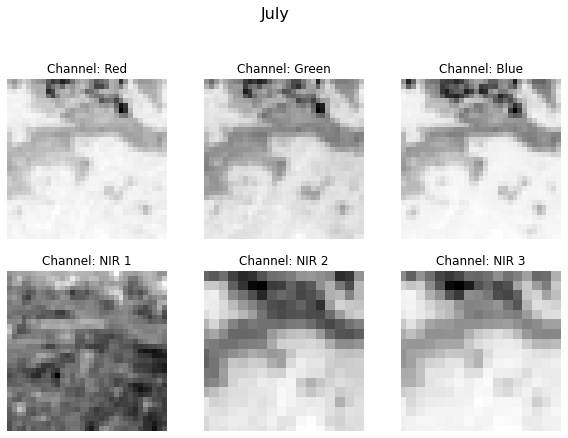

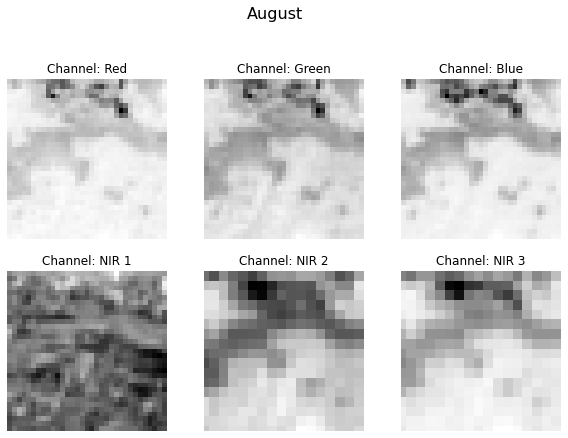

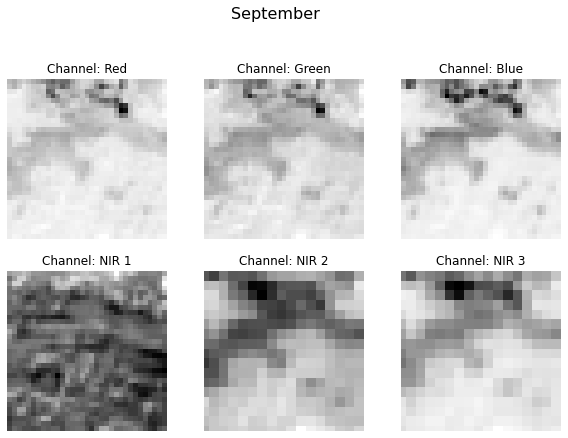

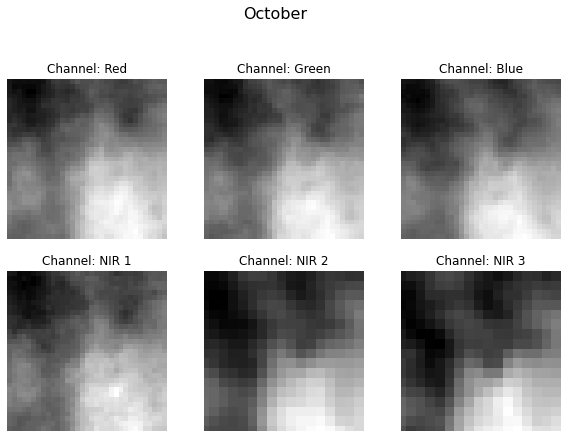

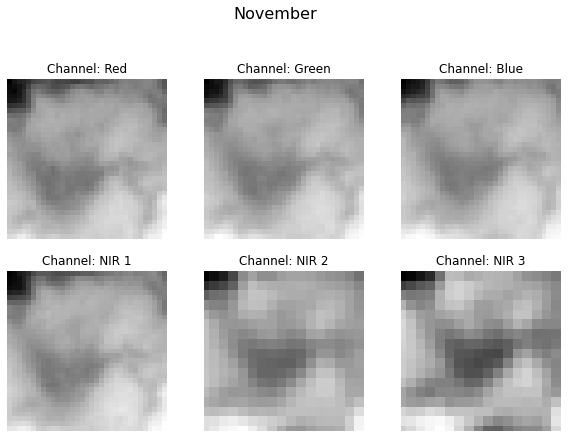

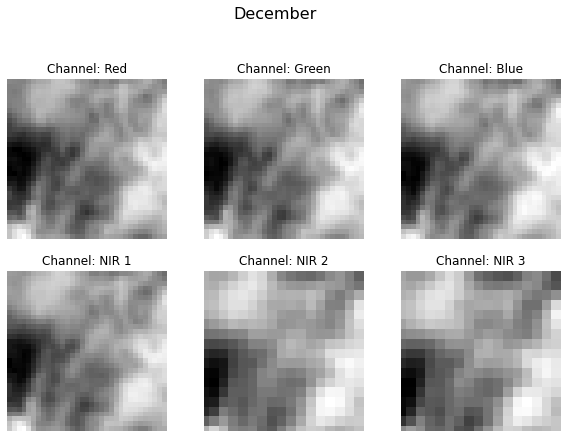

In [7]:
# Show some images

patch = 250 # patch number

print("Channels from patch no. " + str(patch))
print("Central pixel is labeled as " + class_names[lulc[patch]])

for month in range(12):
    plt.figure(figsize=(10, 10))
    for channel in range(6): #show all six channels
        ax = plt.subplot(3, 3, channel+1)
        image = bands[patch, month, :, :, channel]
        plt.imshow(image, cmap = plt.cm.binary)
        plt.title("Channel: " + channel_names[channel+1])
        plt.suptitle(calendar.month_name[month+1], size=16)
        plt.axis("off")

**Build 3D CNN Model from scratch**

adapted by: https://towardsdatascience.com/step-by-step-implementation-3d-convolutional-neural-network-in-keras-12efbdd7b130

In [8]:
base_model = Sequential() # sequential model
base_model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(12,33,33,6)))
base_model.add(MaxPooling3D(pool_size=(2, 2, 2)))
base_model.add(BatchNormalization(center=True, scale=True))
base_model.add(Dropout(0.5))
base_model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
base_model.add(MaxPooling3D(pool_size=(2, 2, 2)))
base_model.add(BatchNormalization(center=True, scale=True))
base_model.add(Dropout(0.5))
base_model.add(Flatten())
base_model.add(Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer='he_uniform')) #leaky relu and not standard one
base_model.add(Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer='he_uniform')) #leaky relu and not standard one
base_model.add(Dense(11, activation='softmax')) # number of outputs, in our case eleven different classes

In [9]:
# Compile the base_model
base_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 10, 31, 31, 32)    5216      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 5, 15, 15, 32)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 15, 15, 32)     128       
_________________________________________________________________
dropout (Dropout)            (None, 5, 15, 15, 32)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 3, 13, 13, 64)     55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 1, 6, 6, 64)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 6, 6, 64)       2

**Split data into train, validation and test data**

In [11]:
X = bands
y = lulc
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.20)

**Calculate class weights automatically** 

In [12]:
class_weights_array = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
#automatic conversion to dictionarry does not work since not represented 
#classes are not included in the class_weights array

class_weights_dict = {
    0: class_weights_array[0],
    1: class_weights_array[1],
    2: class_weights_array[2],
    3: class_weights_array[3],
    4: class_weights_array[4],
    5: class_weights_array[5],
    6: 0,
    7: 0,
    8: class_weights_array[6],
    9: class_weights_array[7],
    10: 0,
}

print(class_weights_dict)

{0: 0.9512485136741974, 1: 5.442176870748299, 2: 0.21407546160021407, 3: 1.0914051841746248, 4: 1.6985138004246285, 5: 20.0, 6: 0, 7: 0, 8: 6.0606060606060606, 9: 2.6755852842809364, 10: 0}


**Fitting Models**

In [13]:
#%%script false
history = base_model.fit(X_train, y_train, epochs=5, batch_size=32, 
                    validation_data=(X_val, y_val),
                    class_weight=class_weights_dict)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/5
200/200 [==============================] - 51s 26ms/step - loss: 2.7419 - accuracy: 0.2271 - val_loss: 2.1856 - val_accuracy: 0.1213
Epoch 2/5
200/200 [==============================] - 4s 22ms/step - loss: 1.7636 - accuracy: 0.3113 - val_loss: 1.8709 - val_accuracy: 0.3212
Epoch 3/5
200/200 [==============================] - 4s 22ms/step - loss: 1.5339 - accuracy: 0.3639 - val_loss: 1.2301 - val_accuracy: 0.5713
Epoch 4/5
200/200 [==============================] - 4s 22ms/step - loss: 1.3153 - accuracy: 0.4512 - val_loss: 1.3914 - val_accuracy: 0.4656
Epoch 5/5
200/200 [==============================] - 4s 22ms/step - loss: 1.3139 - accuracy: 0.4444 - val_loss: 1.2628 - val_accuracy: 0.5644


In [18]:
#%%script false
base_model.save('../modelels/trainingData_5Epochs.h5') # save model in root directory
#model = keras.models.load_model('../modelels/trainingData_5Epochs.h5')

**Evaluation**

In [16]:
%%script false
# Calculate loss and accuracy
base_model.evaluate(X_test, y_test)
#63/63 [==============================] - 18s 288ms/step - loss: 0.8801 - accuracy: 0.6990

# Predicitions with test-set
y_pred = base_model.predict_classes(X_test)
plt.figure(figsize=(10, 10))
print("Predictions of Channel Red in January for nine test pictures:")
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[i, 0, :, :, 0], cmap = plt.cm.binary)
    plt.title("Predicition: " + str(y_pred[i]) + "; True label: " + str(y_test[i]))
    plt.axis("off")

In [ ]:
%%script false
#Plot accuracy and loss of train and val set
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(history.history['accuracy'], color="green")
plt.plot(history.history['val_accuracy'], color="blue")
plt.title("Accuracy", fontsize=16)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.subplot(122)
plt.plot(history.history['loss'], color="red",)
plt.plot(history.history['val_loss'], color="orange")
plt.title("Loss", fontsize=16)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

**Testing on Public Test Set**

In [19]:
data_public_test = np.load(root_path + '/public_test.npz') # load public test set
bands_public_test = data_public_test['bands'] # extract only layer called 'bands'
print(bands_public_test.shape)

(12, 500, 500, 6)


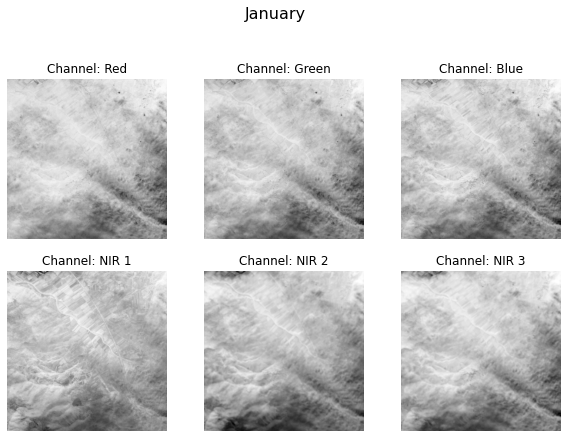

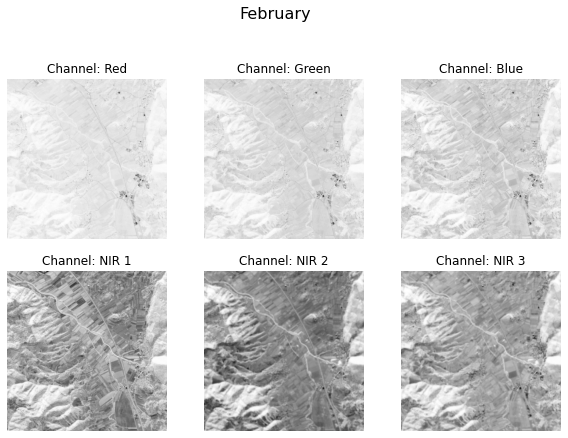

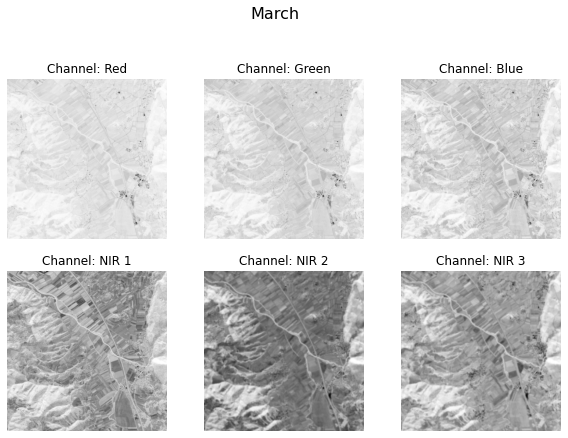

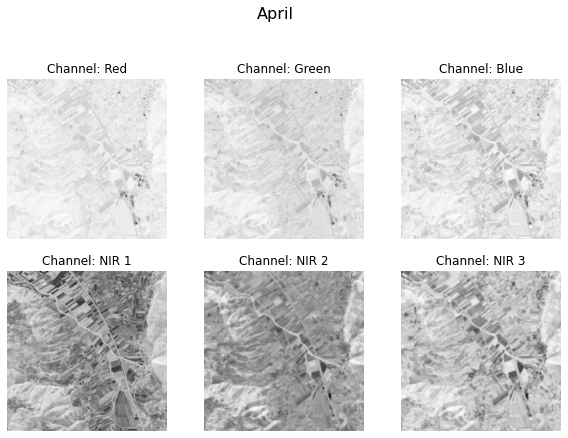

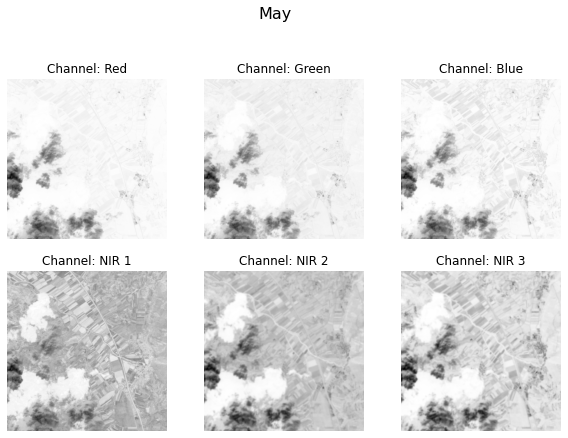

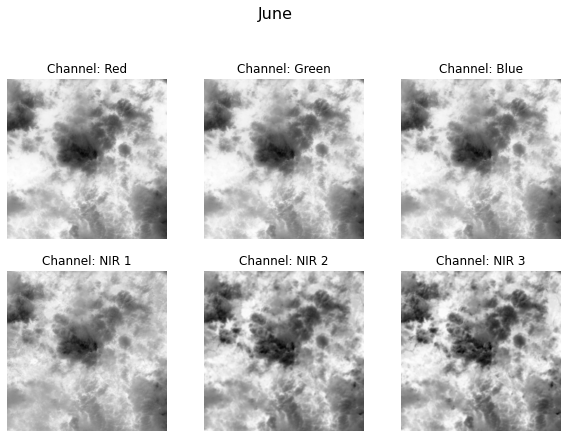

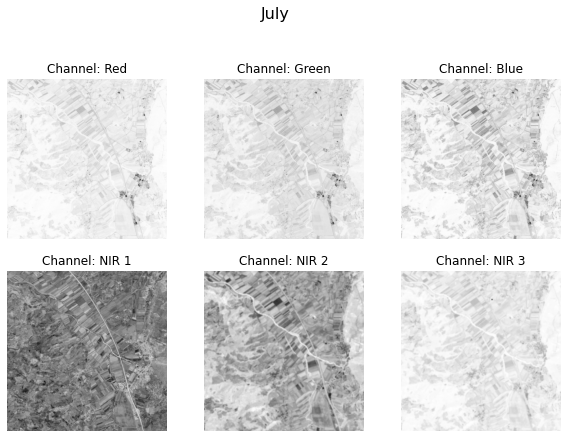

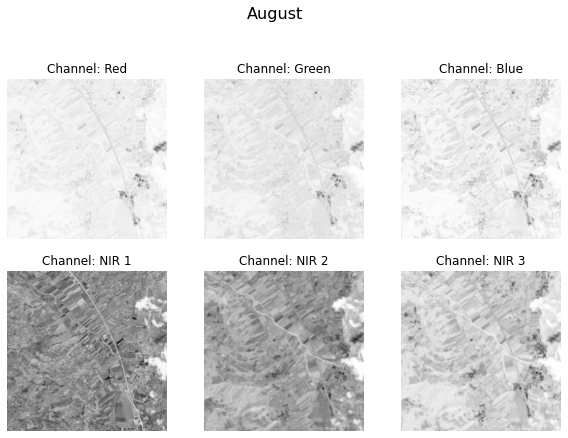

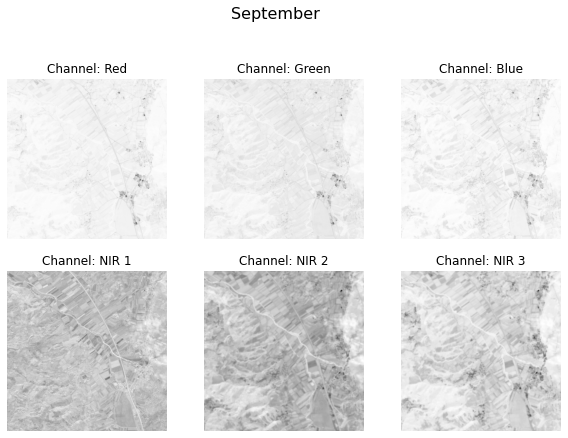

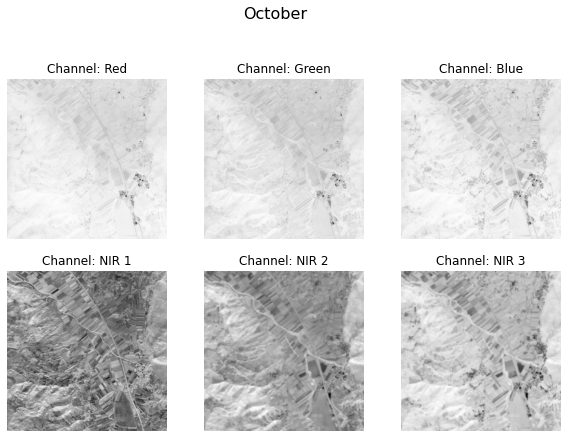

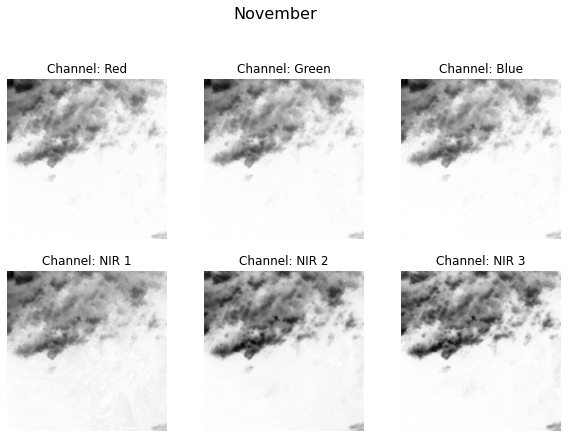

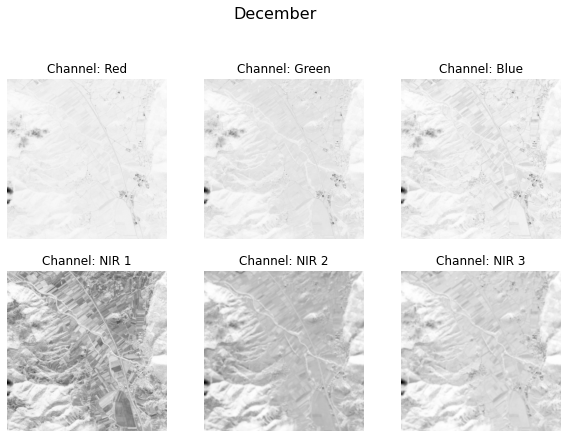

In [20]:
# Show all 12 monthly images of the public test set

for month in range(12):
    plt.figure(figsize=(10, 10))
    for channel in range(6): #show all six channels
        ax = plt.subplot(3, 3, channel+1)
        image = bands_public_test[month, :, :, channel]
        plt.imshow(image, cmap = plt.cm.binary)
        plt.title("Channel: " + channel_names[channel+1])
        plt.suptitle(calendar.month_name[month+1], size=16)
        plt.axis("off")

**Padding**

To be able to use the sliding window approach on the public test set.

In [21]:
bands_public_test_pad = np.zeros(shape=(12, 532, 532, 6)) # get empty array with correct shape

# perform padding for all images (months and channels)
for month in range(12):
    for channel in range(6):
        bands_public_test_pad[month, :, :,channel] = np.pad(bands_public_test[month, :, :,channel],
                                                            ((16,16),(16,16)), 'constant')
        
print(bands_public_test_pad.shape)

(12, 532, 532, 6)


Test padding by printing out the images of the public test set.

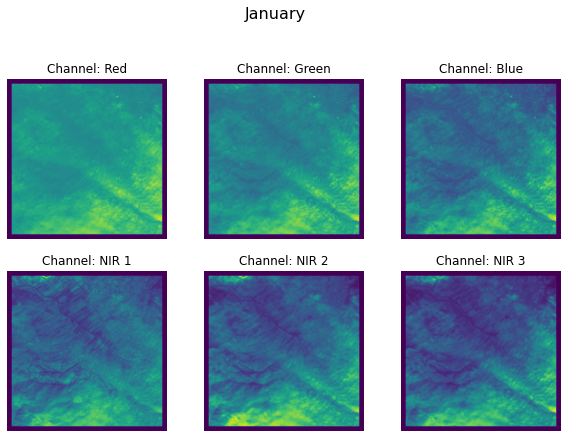

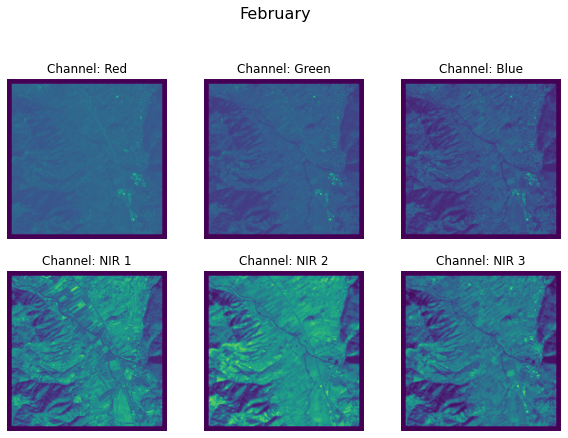

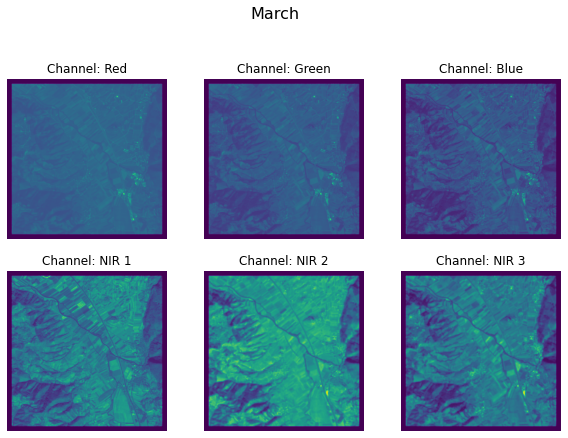

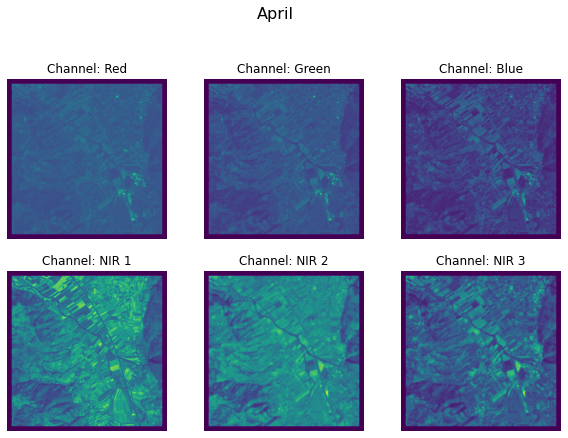

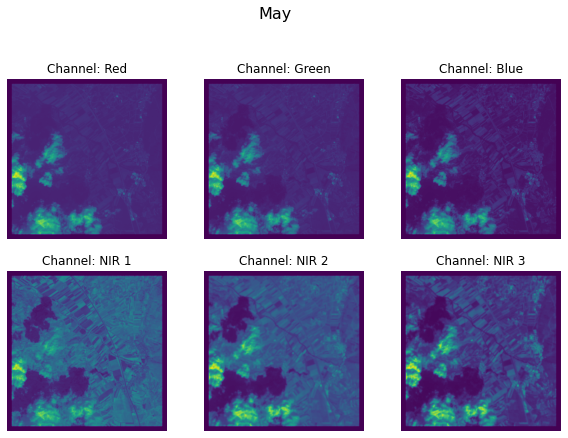

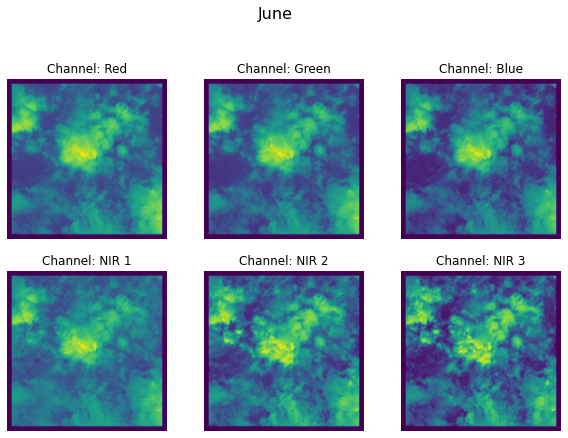

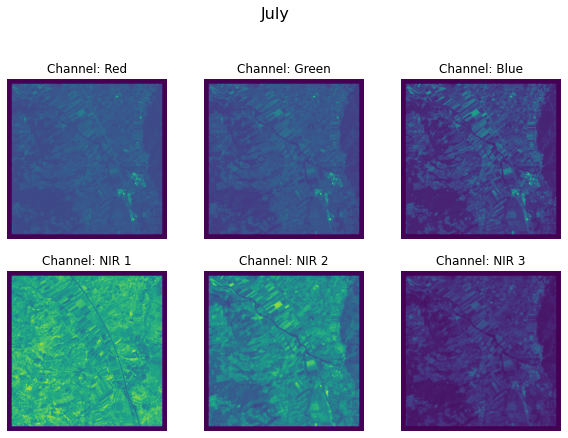

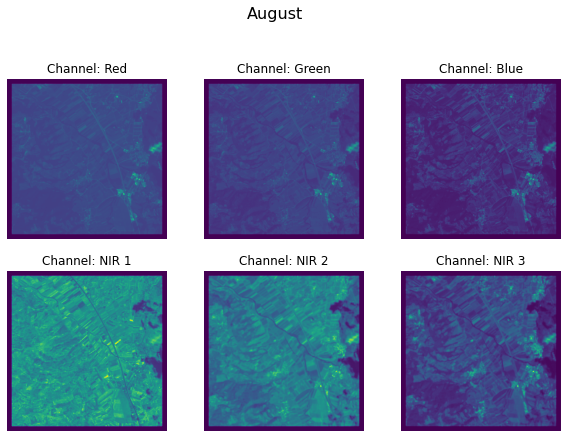

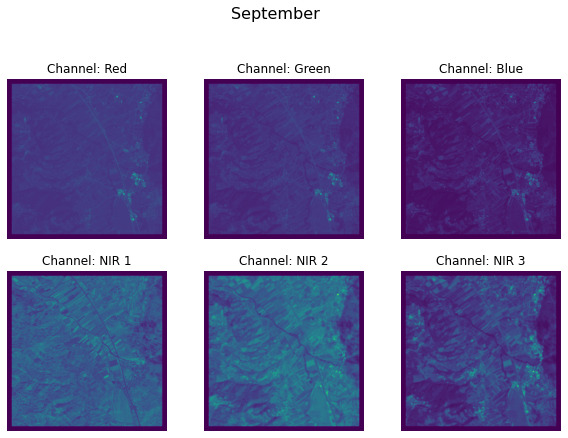

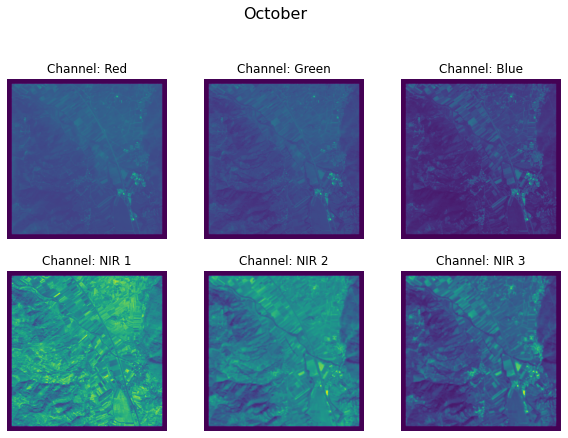

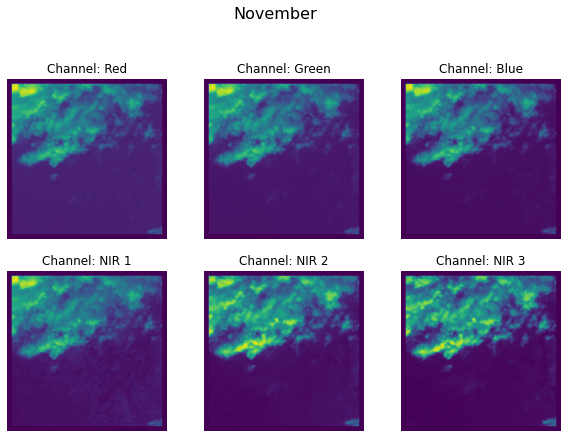

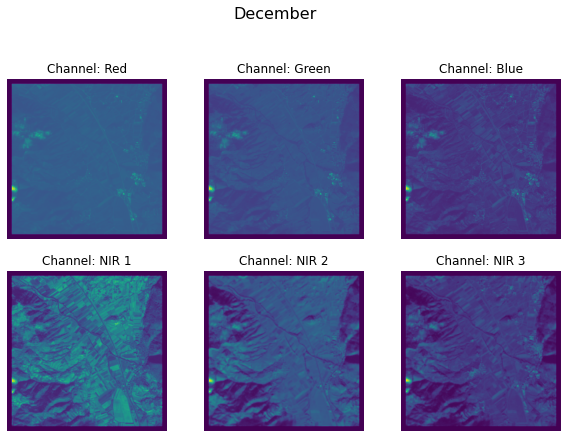

In [22]:
for month in range(12):
    plt.figure(figsize=(10, 10))
    for channel in range(6): #show all six channels
        ax = plt.subplot(3, 3, channel+1)
        image = bands_public_test_pad[month, :, :, channel]
        plt.imshow(image)
        plt.title("Channel: " + channel_names[channel+1])
        plt.suptitle(calendar.month_name[month+1], size=16)
        plt.axis("off") 

In [23]:
# add one dimension to be able feeding our model

#bands_public_test = np.expand_dims(bands_public_test, 0)
bands_public_test_pad = np.expand_dims(bands_public_test_pad, 0)
bands_public_test_pad.shape

(1, 12, 532, 532, 6)

**Naive sliding window approach**

Iterate the model over the whole public test image with stepsize one.

In [32]:
#print(current_cutout.shape) #(1, 12, 33, 33, 6)
#y_pred_public_test = np.zeros(shape=(532, 532, 1)) #468 nachher?
y_pred_public_test = [[0]*532]*532

#len(y_pred_public_test[5])
y_pred_public_test[2][531]

0

In [ ]:
for i in range(468):
    x_coord_end   += 1
    x_coord_start += 1
    y_coord_start = 15
    y_coord_end = y_coord_start + 33
    for j in range(468):
        y_coord_end   += 1
        y_coord_start += 1
        # pass every month & color channel 
        current_cutout = bands_public_test_pad[:, :, x_coord_start:x_coord_end, y_coord_start:y_coord_end, :] 
        #maybe month:month+1 with extra month loop (problematic, because you overwrite previous prediction
        
        y_pred = base_model.predict_classes(current_cutout)
        y_pred_public_test[i][j] = y_pred[0]
        #print(y_pred_public_test)
        
        #Debugging
        #print("i: "+ str(i) + "  j: " + str(j)        + "  -  " +
        #      str(x_coord_start)+":"+str(x_coord_end) + "; "    +
        #      str(y_coord_start)+":"+str(y_coord_end) + "  -  " +
        #      str(int(y_pred_public_test[i][j])))
        #if(current_cutout.shape != (1, 12, 33, 33, 6)): 
            #print(str(current_cutout.shape) + "\n")

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
y_pred_public_test = numpy.array(y_pred_public_test) #convert list to numpy array

In [ ]:
%%script false
with open("y_pred_public_test.npy", "wb") as f:
    np.save(f, y_pred_public_test)

In [ ]:
%%script false
with open("y_pred_public_test.npy", "rb") as f:
    file = np.load(f)
file

**Visualization of the result for the public test set**

Code adapted from https://stackoverflow.com/questions/37719304/python-imshow-set-certain-value-to-defined-color

In [ ]:
color_map = {
    0:  np.array([  0,   0,   0]), #0: "No Data"
    1:  np.array([240, 222,  60]), #1: "Cultivated Land"
    2:  np.array([ 47, 102,  31]), #2: "Forest"
    3:  np.array([162, 232, 142]), #3: "Grassland"
    4:  np.array([162, 176, 158]), #4: "Shrubland"
    5:  np.array([ 99, 189, 224]), #5: "Water"
    6:  np.array([ 44, 209, 154]), #6: "Wetlands"
    7:  np.array([230, 189,  41]), #7: "Tundra"
    8:  np.array([237,  82,  55]), #8: "Artificial Surface"
    9:  np.array([224, 180, 132]), #9: "Bareland"
    10: np.array([189, 189, 189]), #10: "Snow and Ice"
} 

# make a 3d numpy array that has a color channel dimension   
data_3d = np.ndarray(shape=(file.shape[0], file.shape[1]), dtype=int)
for i in range(0, file.shape[0]):
    for j in range(0, file.shape[1]):
        data_3d[i][j] = color_map[file[j,i,0]]
        print(data_3d[i][j])

# display the plot 
fig, ax = plt.subplots(1,1)
ax.imshow(data_3d)

# add numbers to the plot 
for i in range(0, file.shape[0]):
    for j in range(0, file.shape[1]):
        c = file[j,i,0]
        ax.text(i, j, str(c), va='center', ha='center')

In [ ]:
%%script false
print(data_3d.shape)
plt.imshow(file, interpolation='none')
plt.show()